In [1]:
import torch
import numpy as np
import math
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


## Parameters

In [2]:
BATCH_SIZE = 10
learning_rate = 0.001
device = torch.device('cuda')

## Dataset and Augmentations

In [55]:


# Train augmentations
transformations = transforms.Compose([
    # Add training augmentations here, remember: we do not want to transform the validation images.
    # For information about augmentation see: https://pytorch.org/vision/stable/transforms.html
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.RandomVerticalFlip(p=0.5)

    
])

# Data transforms for different folders, call data_transforms['train'] for example.
# We are creating dictionaries for the transforms, dataloaders and datasets in order to keep the code compact.
data_transforms = {
    'train': transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomRotation(degrees=(30, 70),),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize(size=(512,512))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(512,512))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(512,512))
    ]),
}


# Data directory to new folder with a train, validation and test folder split as 0.6, 0.2, 0.2
# Needed to import os in order to join paths.
DATA_DIR = r"C:\Users\Olle\Desktop\chest_xray"
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), 
                                         data_transforms[x]) for x in ['train', 'val','test']}

# Again call dataloaders_dict['val'] for example to use the val dataloader as usual.
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, 
                                                   shuffle=True) for x in ['train', 'val','test']}

# Converting in order to keep the notation used here.
train_loader = dataloaders_dict['train']
val_loader = dataloaders_dict['val']
test_loader = dataloaders_dict['test']

nr_of_batches = len(train_loader)

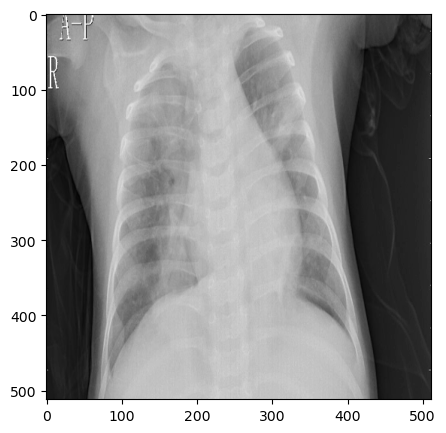

torch.Size([10, 3, 512, 512])


In [77]:
im1 = image_datasets.values
for (images, _) in train_loader:
    plt.imshow(images[1][0], cmap = 'gray')
    plt.show()
    break

train_loader.dataset
h=iter(train_loader)
print(next(h)[0].size())

## CNN Architecture

In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 125 * 125, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        # Implement the forward function in the network
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 125 * 125)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Implement a train model function so you can re_use it in task 3 and 4. 
# Should return the best performing model after training
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    loss_val = []
    loss_train = []
    for epoch in range(num_epochs):
        for batch_nr, (data,labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            prediction = model(data)
            loss = criterion(prediction,labels)
            loss_train.append(torch.Tensor.cpu(loss).detach().numpy())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print(
            f'\rEpoch % {round(float(batch_nr/(nr_of_batches-1)*100),2)} - Loss: {loss_train[-1]}',end='')
            with torch.no_grad():
                for batch_nr, (data,labels) in enumerate(val_loader):
                    data = data.to(device)
                    labels = labels.to(device)
                    prediction_val = model(data)
                    loss_v = criterion(prediction_val,labels)
                    loss_val.append(torch.Tensor.cpu(loss_v).detach().numpy())
            
    plt.rcParams['figure.figsize'] = [5, 5]
    
    plt.plot(range(0,len(loss_train)),loss_train)
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.title('Training Set')
    plt.show()
    
    plt.plot(range(0,len(loss_val)),loss_val)
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.title('Validation Set')
    plt.show()
    return model
    

## Training

Epoch % 100.0 - Loss: 0.3042949140071869415

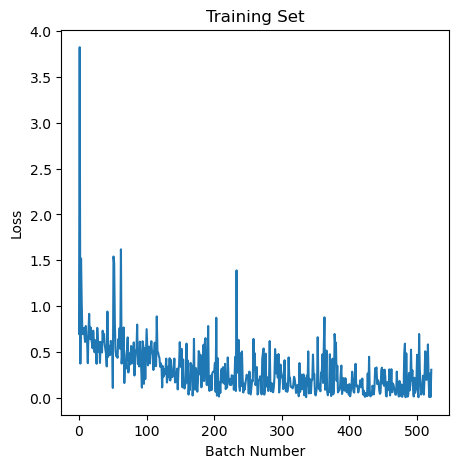

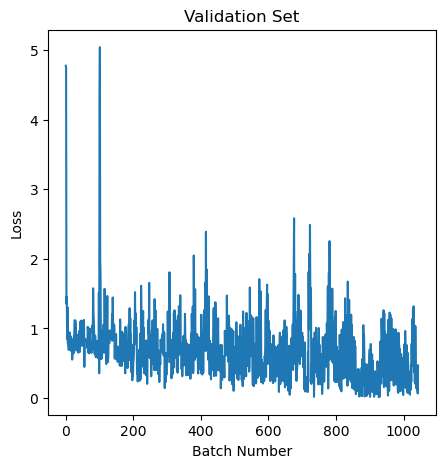

In [58]:
model = Net()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

trained_model = train_model(model, loss_fn, optimizer, train_loader, val_loader, 1)

In [6]:
torch.cuda.empty_cache() 

In [61]:
correct = 0
total = 0
y_pred = []
y_true = []
with torch.no_grad():
    for batch_nr, data in enumerate(val_loader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred = np.concatenate((y_pred,torch.Tensor.cpu(predicted)))
        y_true = np.concatenate((y_true,torch.Tensor.cpu(labels)))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the validation set images: {100 * correct // total} %')

Accuracy of the network on the validation set images: 93 %
